# Ray Tracing Canonical Examples

In [60]:
# data handling
import numpy    as np
import xarray   as xr

# plotting
import matplotlib.pyplot    as plt
from   IPython.display      import HTML
import cmocean

# ray tracing
import mantaray

# helper functions
import utils

## Introduction

This notebook covers how to run Mantaray with the custom depth and current fields that were constructed in `idealized_fields.ipynb`. It is recommended that users run through this notebook first.

## Initial Wave and Model Parameters

The initial wave parameters that we need to define for Mantaray are $k_{x0}$/$k_{y_0}$, the initial x/y wavenumber. We will calculate these from the following parameters:
- $T_0$: The initial way period,
- $\theta_0$: The initial wave direction (convention: what direction the waves are *going to*),
- $n_{rays}$: The number of rays.

All waves will have the same x/y wavenumbers. We will use these initial parameters for the 4 canonical examples.

In [3]:
T0      = 10 # Period [s]
theta0  = 0  # Direction [rad]

In [4]:
# Convert period to wavenumber magnitude
k_0 = utils.period2wavenumber(T0)

# Calculate wavenumber components
k_x0 = k_0 * np.cos(theta0)
k_y0 = k_0 * np.sin(theta0)

In [5]:
# Number of rays
n_rays = 100

# Initialize wavenumber for all rays
K_x0 = k_x0 * np.ones(n_rays)
K_y0 = k_y0 * np.ones(n_rays)

Additionally, we need to define the initial positions for all of our rays. To do this, we will extract the grid from one of our canonical examples. All examples have the same grid, and the initial positions for all rays will be the same for each canonical example.

In [6]:
ds_jet = xr.open_dataset('./data/currents/jet.nc')

In [7]:
# Read x and y from file to get domain size
x = ds_jet.x.values
y = ds_jet.y.values

In [8]:
x0 = 0 * np.ones(n_rays)
y0 = np.linspace(0, y.max(), n_rays)

Additionally, using the grid, we can compute the optimal timestep and duration for each model.

In [9]:
timestep = utils.compute_cfl(x, y, k_0)
duration = utils.compute_duration(x, k_0)

## Ray Tracing with Mantaray

Now that we have defined the initial wave and model parameters, we can run the core function of Mantaray `mantaray.ray_tracing()` to trace the paths that the waves would take.

In [10]:
mantaray.ray_tracing?

Signature:
mantaray.ray_tracing(
    x0,
    y0,
    kx0,
    ky0,
    duration: float,
    step_size: float,
    bathymetry: str,
    current: str,
) -> xarray.core.dataset.Dataset
Docstring:
Ray tracing for multiple initial conditions

For a given set of initial conditions, progapage those multiple rays in
parallel and return the projections for each ray

Parameters
----------
x0 : Sequence[float]
    Initial x position of the ray
y0 : Sequence[float]
    Initial y position of the ray
kx0 : Sequence[float]
    Initial wavenumber, x component
ky0 : Sequence[float]
    Initial wavenumber, y component
duration : float
    Duration of the simulation
step_size : float
    Time step for the simulation
bathymetry : str
    Path to a netCDF file containing the bathymetry file. It is expected
    x and y dimensions as floats and depth (x, y) as a float, where
    depth is zero at surface and positive downwards.
current : str
    Paths to a netCDF file containing the current field. It is expec

The core ray tracing function expects:
- Initial x/y position(s),
- Initial $k_{x0}$/$k_{y0}$(s),
- Model duration,
- Model timestep,
- Bathymetry/Current `xarray` `datasets` *paths* as *strings*

### Zonal Jet

If `idealized_fields.ipynb` was run properly, the paths below should be where the data for the zonal jet and constant bathymetry should be located.

In [11]:
jet_path         = './data/currents/jet.nc'
const_bathy_path = './data/bathymetry/constant.nc'

In [12]:
bundle_jet = mantaray.ray_tracing(x0, y0, K_x0, K_y0, 
                                    duration, timestep, 
                                    const_bathy_path, jet_path)

Our ray tracing code executed properly. We can make a quick plot to see if this is working properly before creating animations.

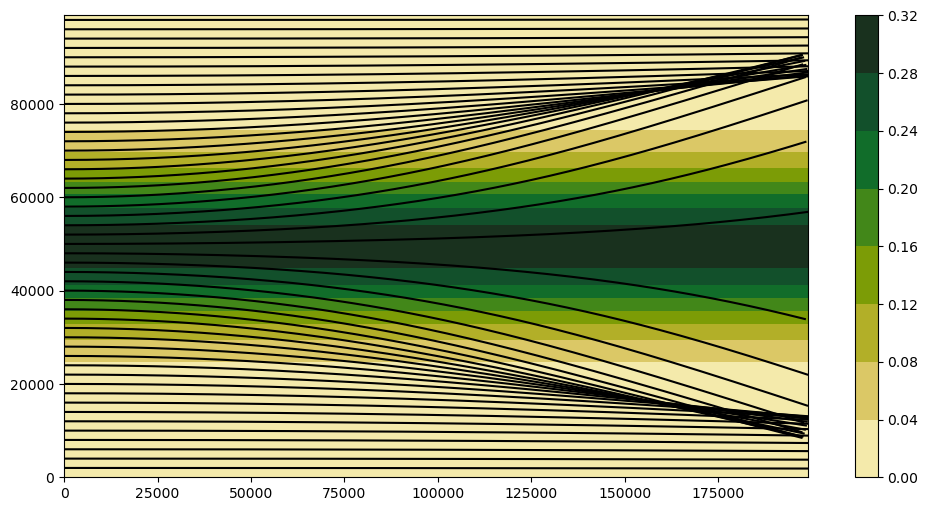

In [13]:
X = ds_jet.x
Y = ds_jet.y
U = (ds_jet.u**2 + ds_jet.v**2)**.5

plt.figure(figsize=(12, 6))

cf = plt.contourf(X, Y, U, cmap=cmocean.cm.speed)

for i in range(bundle_jet.ray.size)[::2]:
    ray = bundle_jet.isel(ray=i)
    plt.plot(ray.x.values, ray.y.values, color='black')

plt.colorbar(cf)

### Mesoscale Eddy

In [14]:
eddy_path = './data/currents/eddy.nc'

In [15]:
bundle_eddy = mantaray.ray_tracing(x0, y0, K_x0, K_y0, 
                                    duration, timestep, 
                                    const_bathy_path, eddy_path)

In [16]:
ds_eddy = xr.open_dataset(eddy_path)

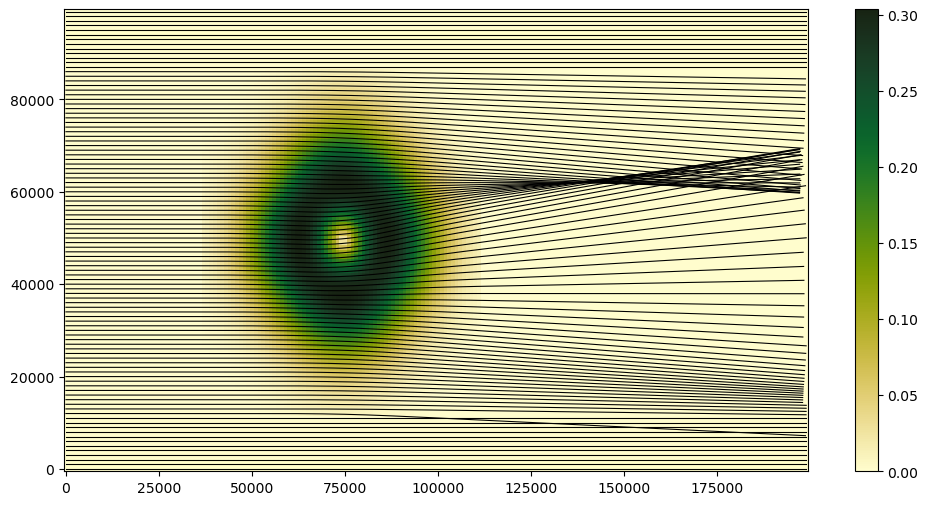

In [17]:
X = ds_eddy.x
Y = ds_eddy.y
U = (ds_eddy.u**2 + ds_eddy.v**2)**.5

plt.figure(figsize=(12, 6))

cf = plt.pcolormesh(X, Y, U, cmap=cmocean.cm.speed)

for i in range(bundle_eddy.ray.size)[::1]:
    ray = bundle_eddy.isel(ray=i)
    plt.plot(ray.x, ray.y, 'k', lw=.78)

plt.colorbar(cf)

### Gaussian Island

In [18]:
static_cur_path = './data/currents/homogeneous.nc'
island_path     = './data/bathymetry/island.nc'

In [19]:
bundle_island = mantaray.ray_tracing(x0, y0, K_x0, K_y0, 
                                        duration, timestep, 
                                        island_path, static_cur_path)

In [20]:
ds_island = xr.open_dataset(island_path)

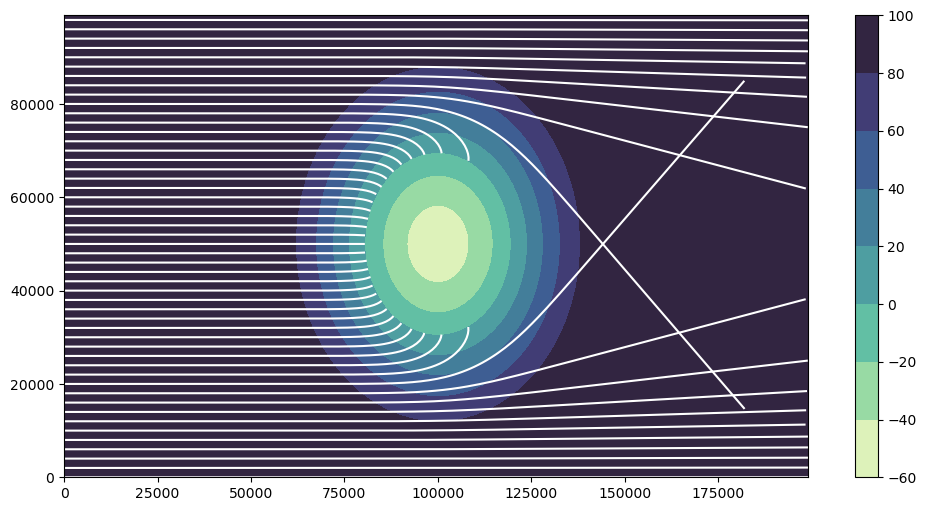

In [21]:
X = ds_eddy.x
Y = ds_eddy.y
H = ds_island.depth

plt.figure(figsize=(12, 6))

cf = plt.contourf(X, Y, H, cmap=cmocean.cm.deep)

for i in range(bundle_island.ray.size)[::2]:
    ray = bundle_island.isel(ray=i)
    plt.plot(ray.x, ray.y, color='white')

plt.colorbar(cf)

## Interactive Animations

Any ray tracing example can be animated. For any example, you need to extract:
- The x/y grid from the currents/bathymetry dataset
- The background field from the currents/bathymetry dataset

In [22]:
X = ds_jet.x
Y = ds_jet.y
U = (ds_jet.u**2 + ds_jet.v**2)**.5

Below, we create the frames of the animation.

In [26]:
jet_anim = utils.animate_rays(X,Y,U,
                                bundle_jet,
                                style='currents', ray_sample=2, time_sample=5)

Then, we can plot the animation so that it is interactive. WARNING: this cell may take some time to run.

In [27]:
HTML(jet_anim.to_jshtml())

Optionally, the animation can be saved.

In [28]:
# anim.save('./output/waves.gif')

## Bonus Examples

### Sloped Beach

For this example, we will start the rays from a line on an angle.

In [50]:
theta0 = np.deg2rad(35)

# Calculate wavenumber components
k_x0 = k_0*np.cos(theta0)
k_y0 = k_0*np.sin(theta0)

In [51]:
n_rays = 50

# Initialize wavenumber for all rays
Kx0 = k_x0 * np.ones(n_rays)
Ky0 = k_y0 * np.ones(n_rays)

The CFL and duration funtions assume that the rays are moving from the left side of the domain to the right, so they are not a perfect estimate here, but they'll still work.

In [31]:
step_size = utils.compute_cfl(x, y, k_0)
duration  = utils.compute_duration(x, k_0)

We have calculated the x/y wavenumber components for waves traveling at 35 degrees, but we now need to define their initial positions along an angled line.

In [52]:
# Parameters
x_start = 5000      # Start x coordinate [m]
y_start = 10        # Start y coordinate [m]
line_length = 5000  # Total length of the line [m]

# Calculate the step size in the x and y directions
dx = -line_length / n_rays * np.cos(np.pi/2 - theta0)
dy = line_length / n_rays * np.sin(np.pi/2 - np.pi/4)

# Generate the coordinates along the line
x0 = x_start + np.linspace(0, dx*(n_rays-1), n_rays)  # x coordinates
y0 = y_start + np.linspace(0, dy*(n_rays-1), n_rays)  # y coordinates

In [53]:
beach_path = './data/bathymetry/beach.nc'

In [56]:
bundle_beach = mantaray.ray_tracing(x0, y0, Kx0, Ky0, 
                                    duration, 10, 
                                    beach_path, static_cur_path)

In [57]:
ds_beach = xr.open_dataset(beach_path)

/var/folders/30/l7lkprrx2c32s7j5y82c67300000gq/T/ipykernel_45485/36045105.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(ray.x, ray.y, 'k', lw=.78, color='white')


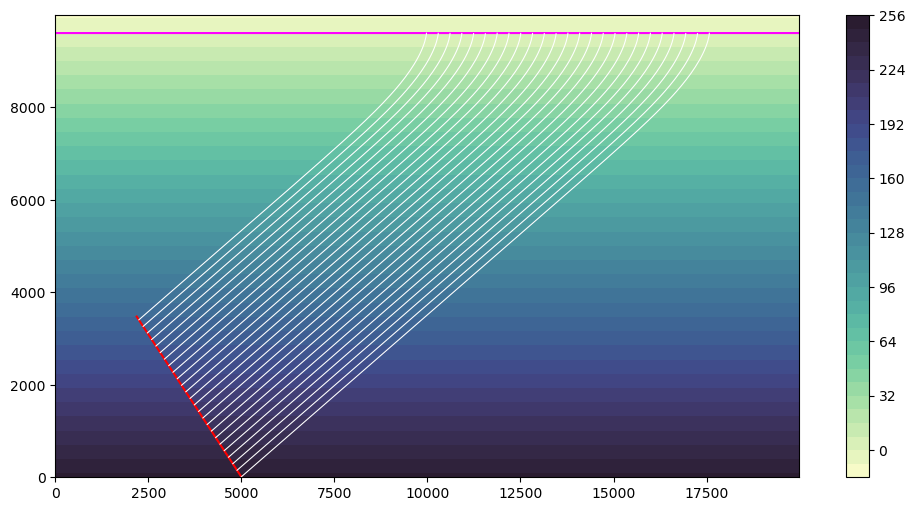

In [59]:
X = ds_beach.x
Y = ds_beach.y
H = ds_beach.depth

plt.figure(figsize=(12, 6))

cf = plt.contourf(X, Y, H, cmap=cmocean.cm.deep, levels=40)
line = plt.plot(x0, y0, label="Line at points (x0, y0)", color='red')

plt.contour(X, Y, H, 0, colors='magenta')


for i in range(bundle_beach.ray.size)[::2]:
    ray = bundle_beach.isel(ray=i)
    plt.plot(ray.x, ray.y, 'k', lw=.78, color='white')

plt.colorbar(cf)